In [83]:
#%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from scipy.fftpack import fft, fftfreq
from scipy import signal
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

In [162]:
#create a ECOG PCA class for its PCA object, hyperparas and other stuff
class PCA_Ecog:
    def __init__(self, raw=None, pca_obj=None,wsize=2):
        self.pca=pca_obj
        self.raw=raw
        #hyperpara in s for how large the time window should be on whihc we calculate our fourier trafo
        self.wsize=wsize
        #sampling frequency and last sample taken
        if(self.raw != None):
            self.sfreq=self.raw.info['sfreq']
            self.end=self.raw.time_as_index(len(raw))
        else:
            self.sfreq=None
            self.end=None
        
    #load some EDF data   
    def read_in_raw(self, fpath):
        self.raw=mne.io.read_raw_edf(fpath)
        #TODO exclude bad channels
        self.sfreq=self.raw.info['sfreq']
        self.end=self.raw.time_as_index(len(self.raw))

        
    def demean_and_scale(self, data,ax=0):
        data_dem=data-np.mean(data,axis=ax)
        data_scal=1000000*data_dem
        return data_scal
    
        
    #create matrix as follows:
    #columns: channels, for each channel the 200 frequencies (0-200Hz) (hece freq*cha length)
    #rows: Time steps
    #resulting matrix is 2D, Time Stepsx(Freq*Channels)
    #note that this matrix is prone to constant change. Save the current data as member variable
    def calc_data_mat(self,time_sta,time_stp):
        if(self.raw==None):
            raise ValueError('Raw Data not set.')
        time_it=time_sta
        while True:
            #calculate times in sample points
            start, stop = self.raw.time_as_index([time_it,time_it+self.wsize])
            #get data of ALL channels
            data=self.raw.get_data(start=start,stop=stop,reject_by_annotation=None,return_times=False)
            #welch method
            fr,psd=signal.welch(data,self.sfreq)
            #truncate everythin above 200Hz
            psd=psd[fr<=200]
            if time_it==time_sta:
                #first time. create first column, flatten w/o argument is row major 
                mat=psd.flatten()
            else:
                #after, add column for each time step
                mat=np.column_stack((mat,psd.flatten()))
            time_it+=self.wsize
            if time_it >= time_stp+self.wsize:
                break
        data_scal=self.demean_and_scale(mat.T)
        self.curr_data=data_scal
        return data_scal

    def vis_data_range(self, start, stop, no_chan=None):
        if(self.raw==None):
            raise ValueError('Raw Data not set (yet)')
        st,stp=self.raw.time_as_index([start,stop])
        print(st,stp)
        data=self.raw.get_data(picks=range(1,no_chan+1),start=st,stop=stp,reject_by_annotation=None,return_times=False)
        print(data.shape)
        for p in range(1,no_chan):
            plt.plot(data[p])
        plt.show()


In [163]:
raw_d=mne.io.read_raw_edf('/data1/ecog_project/edf/aa9da7b2/aa9da7b2_5.edf')
pecog=PCA_Ecog(raw=raw_d)


Extracting EDF parameters from /data1/ecog_project/edf/aa9da7b2/aa9da7b2_5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [132]:
##TEST STUFF
###functions for first insight. delete later
start, stop = raw.time_as_index([0, 51+window_size])
print(stop-start)
channel=raw.get_data(picks=[4,5],start=start, stop=stop,reject_by_annotation=None, return_times=False)
#data=np.squeeze(channel[0])

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(channel))
# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(channel[0,:]), 1.0/sfreq)
#welch method
fr,psd=signal.welch(channel,sfreq)

#throw away everything above 100Hz for now (and 0)
freqs=fft_freq[fft_freq<101][1:]
vals=fft_vals[:,fft_freq<101][:,1:]


plt.plot(fr,psd[0])
plt.plot(fr,psd[1])

plt.plot(freqs,vals[1])
plt.plot(freqs,vals[0])

plt.plot(fft_freq[1:], fft_vals[1:])
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.show()
plt.plot(freqs,vals)
#plt.xlabel('Frequency')
#plt.ylabel('Intensity')

NameError: name 'raw' is not defined

In [164]:
data=pecog.calc_data_mat(0,100)

In [142]:
#get elbow curve
def elbow_curve(data):
    components = range(1, data.shape[1] + 1)
    explained_variance = []
    for component in tqdm(components[:50]):
        pca = PCA(n_components=component)
        pca.fit(data)
        explained_variance.append(sum(pca.explained_variance_ratio_))
    sns_plot = sns.regplot(
        x=np.array(components[:50]), y=explained_variance,
        fit_reg=False).get_figure()
    sns_plot.savefig("pca_elbow.png")

In [165]:
#choose first three components
pecog.pca = PCA(n_components=2)
pecog.pca.fit(data_scal)
data_trafo=pecog.pca.transform(data_scal)
print(data_trafo.shape)

(51, 2)


In [166]:
#what are the outstsanding points here?
idx=np.argwhere(data_trafo>2)[:,0]
#what is happening at these points?
#calculate back the time window:
idx=idx*pecog.wsize
#calculate from time windows to sampling points
start, stop = pecog.raw.time_as_index([idx[0]-5,idx[1]+5])
inter=pecog.raw.get_data(picks=range(0,40), start=start, stop=stop,reject_by_annotation=None, return_times=False)
print(inter.shape)

(40, 39977)


(8994, 48971)
(40, 39977)


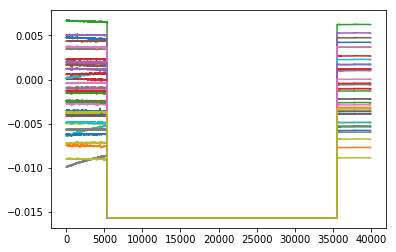

(143915, 443738)
(40, 299823)


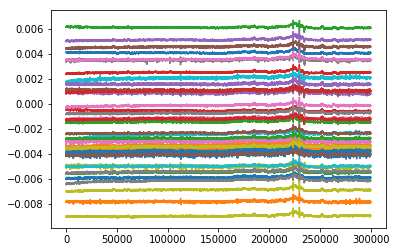

In [167]:
pecog.vis_data_range(idx[0]-5,idx[1]+5, no_chan=40)
pecog.vis_data_range(idx[1]+100,idx[1]+400,no_chan=40)

In [168]:
good_data=pecog.calc_data_mat(idx[1]+100,idx[1]+400)
pecog.pca.fit(good_data)
good_data_trafo=pecog.pca.transform(good_data)
print(good_data_trafo.shape)

(151, 2)


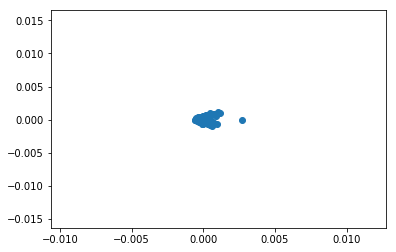

In [169]:
#print(data_trafo)
plt.scatter(good_data_trafo[:,0],good_data_trafo[:,1])
#plt.xlim(-0.00001,0.00001)
#plt.ylim(-0.00001,0.00001)

#max(data_trafo[:,1])-min(data_trafo[:,1])

In [ ]:


#for 3D
# fig = pyplot.figure()
# ax = Axes3D(fig)

# ax.scatter(data_trafo[:,0],data_trafo[:,1],data_trafo[:,2],c='b')
# pyplot.show()